## 1. Laden Sie die Trainingsdaten.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


data_train_raw = pd.read_csv("data/project/train.csv", sep=';')
data_train_raw.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


# 2. Führen Sie eine kurze EDA durch

<Axes: >

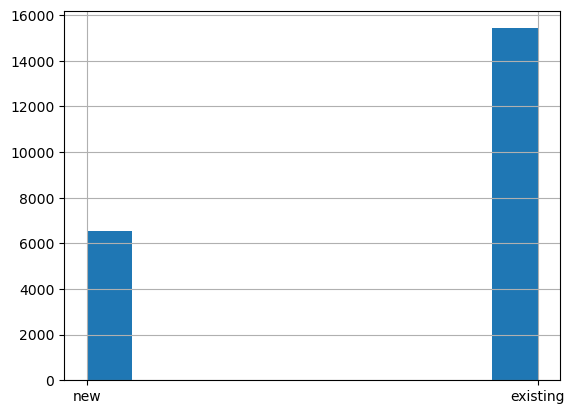

In [2]:
data_train_raw["customerType"].hist()

<Axes: >

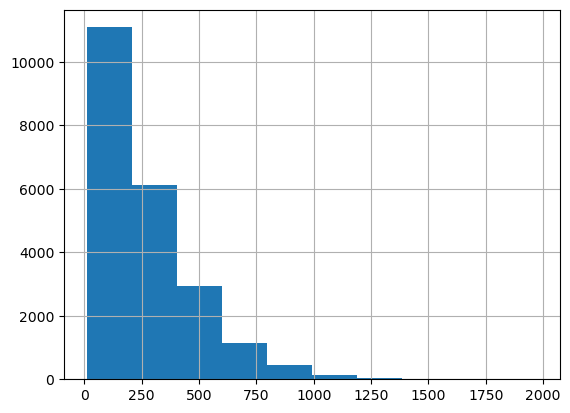

In [3]:
data_train_raw["totalAmount"].hist()

array([<Axes: title={'center': 'existing'}>,
       <Axes: title={'center': 'new'}>], dtype=object)

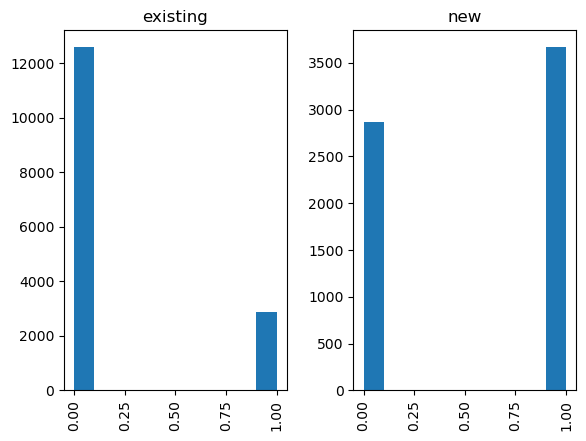

In [4]:
data_train_raw.hist(column="returnLabel", by="customerType")

<Axes: title={'center': 'totalAmount'}, xlabel='returnLabel'>

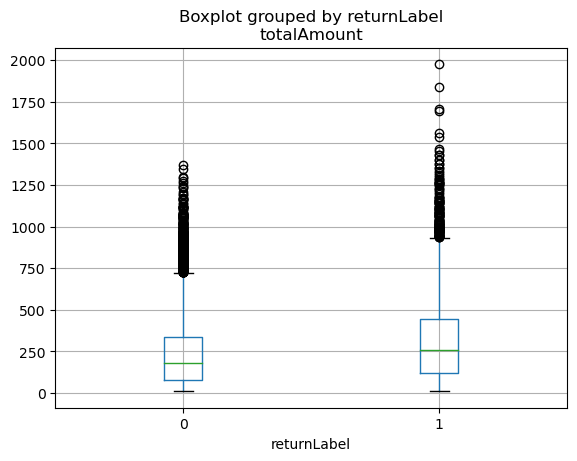

In [5]:
data_train_raw.boxplot(column="totalAmount", by="returnLabel")

D:\Apps\Miniconda\envs\ml-course\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


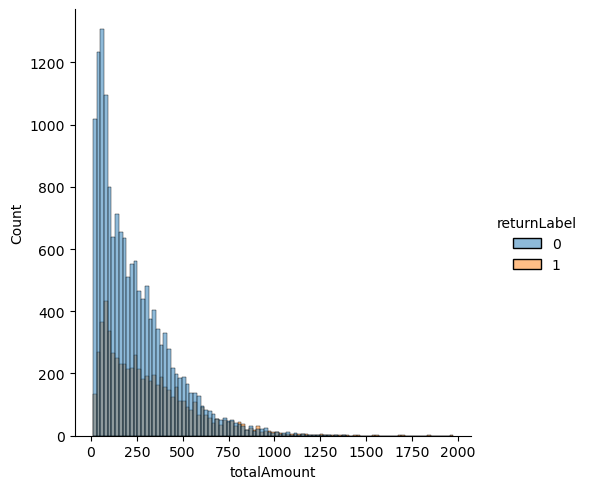

In [6]:
sns.displot(data_train_raw, x="totalAmount", hue="returnLabel")

# 3. Füllen Sie fehlende Werte in den Trainingsdaten auf

In [7]:
data_train_raw.isna().sum()

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64

In [8]:
data_train_no_nan=data_train_raw.copy()
data_train_no_nan['customerType'].fillna(data_train_no_nan['customerType'].mode()[0], inplace=True)
data_train_no_nan['totalAmount'].fillna(data_train_no_nan['totalAmount'].mean(), inplace=True)

In [9]:
data_train_raw.isna().sum()

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64

# 4. Transformieren Sie die kategorischen Features mittels One-hot-encoding

In [10]:
data_train_encoded = pd.get_dummies(data_train_no_nan, columns=['customerType'])
data_train_encoded.head()

,transactionId,basket,totalAmount,returnLabel,customerType_existing,customerType_new
0,9534310106,"[4, 3, 4]",252.0,1,False,True
1,7202594767,"[4, 2, 0, 2, 5]",70.0,0,True,False
2,2737331698,[5],84.0,0,True,False
3,4868011733,"[1, 4, 2, 4]",116.0,0,True,False
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,0,True,False


# 5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft kommt jede Kategorie im Basket vor)

In [11]:
categories = ['0','1','2','3','4','5']
data_train_with_in_basket_cats = data_train_encoded.copy()
for c in categories:
    data_train_with_in_basket_cats['in_basket_cat_'+c] = data_train_with_in_basket_cats["basket"].map(lambda x: x.count(c))
data_train_with_in_basket_cats.drop('basket', axis=1, inplace=True)
data_train_with_in_basket_cats.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,in_basket_cat_0,in_basket_cat_1,in_basket_cat_2,in_basket_cat_3,in_basket_cat_4,in_basket_cat_5
0,9534310106,252.0,1,False,True,0,0,0,1,2,0
1,7202594767,70.0,0,True,False,1,0,2,0,1,1
2,2737331698,84.0,0,True,False,0,0,0,0,0,1
3,4868011733,116.0,0,True,False,0,1,1,0,2,0
4,7622406570,378.0,0,True,False,1,0,3,2,0,1


# 6. Skalieren Sie die Features mit einem StandardScaler

In [12]:
scaler = StandardScaler()
data_train_scaled = data_train_with_in_basket_cats.copy()
data_train_scaled['totalAmount'] = scaler.fit_transform(data_train_scaled[['totalAmount']])
data_train_scaled.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,in_basket_cat_0,in_basket_cat_1,in_basket_cat_2,in_basket_cat_3,in_basket_cat_4,in_basket_cat_5
0,9534310106,-0.032823,1,False,True,0,0,0,1,2,0
1,7202594767,-0.879459,0,True,False,1,0,2,0,1,1
2,2737331698,-0.814334,0,True,False,0,0,0,0,0,1
3,4868011733,-0.665475,0,True,False,0,1,1,0,2,0
4,7622406570,0.553309,0,True,False,1,0,3,2,0,1


# 7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die angegebenen Hyperparameter mittels Cross-Validation aus:
### 1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]

In [13]:
data_train_scaled_X = data_train_scaled.drop(columns=['returnLabel'])
data_train_scaled_y = data_train_scaled['returnLabel']

lr = LogisticRegression(solver='liblinear', max_iter=1000)  # saga unterstützt l1 und l2 Penalty
param_grid = {
    'C': [0.1, 1, 4, 5, 6, 10, 30, 100],
    'penalty': ['l1', 'l2']
}

lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

lr_grid.fit(data_train_scaled_X, data_train_scaled_y)
lr_best_params_ = lr_grid.best_params_
print("Beste Hyperparameter:")
print(lr_best_params_)
print("Bester score:")
print(lr_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Beste Hyperparameter:
{'C': 1, 'penalty': 'l1'}
Bester score:
0.8785714285714287


D:\Apps\Miniconda\envs\ml-course\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 7.2 Random Forest: `n_estimators: [60, 80, 100, 120, 140]` und `max_depth: [2, 4, 6]`

In [14]:
rf = RandomForestClassifier(random_state=0)
param_grid = {
    'n_estimators': [60, 80, 100, 120, 140],
    'max_depth': [2, 4, 6]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

rf_grid.fit(data_train_scaled_X, data_train_scaled_y)
rf_best_params_ = rf_grid.best_params_
print("Beste Hyperparameter:")
print(rf_best_params_)
print("Bester score:")
print(rf_grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Beste Hyperparameter:
{'max_depth': 6, 'n_estimators': 60}
Bester score:
0.8687946428571429


### 7.3 Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

In [15]:
gbt = GradientBoostingClassifier(random_state=0)
param_grid = {
    'n_estimators': [60, 80, 100, 120, 140],
    'max_depth': [2, 4, 6]
}

gbt_grid = GridSearchCV(estimator=gbt, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

gbt_grid.fit(data_train_scaled_X, data_train_scaled_y)
gbt_best_params_ = gbt_grid.best_params_
print("Beste Hyperparameter:")
print(gbt_best_params_)
print("Bester score:")
print(gbt_grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Beste Hyperparameter:
{'max_depth': 6, 'n_estimators': 80}
Bester score:
0.8787946428571429


## 8. Laden sie die Testdaten.

In [17]:
data_test = pd.read_csv("data/project/test.csv", sep=";")
data_test.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0


## 9. Entfernen Sie alle Zeilen mit fehlenden Werten.

In [18]:
data_test_na_droped = data_test.dropna()
data_test_na_droped.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0


## 10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

In [19]:
data_test_encoded = pd.get_dummies(data_test_na_droped, columns=["customerType"])
data_test_encoded.head()

,transactionId,basket,totalAmount,returnLabel,customerType_existing,customerType_new
0,4132523932,"[4, 3, 4, 3, 2, 3]",366.0,1,True,False
1,8998574539,"[3, 4, 4, 3, 5]",85.0,0,True,False
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",275.0,0,True,False
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",528.0,0,True,False
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",287.0,0,True,False


In [20]:
data_test_with_in_basket_cats = data_test_encoded.copy()
for c in categories:
    data_test_with_in_basket_cats['in_basket_cat_'+c] = data_test_with_in_basket_cats["basket"].map(lambda x: x.count(c))
data_test_with_in_basket_cats.drop('basket', axis=1, inplace=True)
data_test_with_in_basket_cats.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,in_basket_cat_0,in_basket_cat_1,in_basket_cat_2,in_basket_cat_3,in_basket_cat_4,in_basket_cat_5
0,4132523932,366.0,1,True,False,0,0,1,3,2,0
1,8998574539,85.0,0,True,False,0,0,0,2,2,1
2,9346688547,275.0,0,True,False,1,4,2,2,2,0
3,4533897707,528.0,0,True,False,1,3,2,1,0,1
4,3334800500,287.0,0,True,False,0,1,2,1,1,2


## 11. Skalieren Sie die Daten im gleichen Maß wie die Trainingsdaten.

In [21]:
data_test_scaled = data_test_with_in_basket_cats.copy()
data_test_scaled['totalAmount'] = scaler.fit_transform(data_test_scaled[['totalAmount']])
data_test_scaled.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,in_basket_cat_0,in_basket_cat_1,in_basket_cat_2,in_basket_cat_3,in_basket_cat_4,in_basket_cat_5
0,4132523932,0.462354,1,True,False,0,0,1,3,2,0
1,8998574539,-0.800293,0,True,False,0,0,0,2,2,1
2,9346688547,0.053454,0,True,False,1,4,2,2,2,0
3,4533897707,1.190286,0,True,False,1,3,2,1,0,1
4,3334800500,0.107375,0,True,False,0,1,2,1,1,2


## 12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den jeweils besten Hyperparametern aus der Cross Validation.

In [22]:
data_test_scaled_X = data_test_scaled.drop(columns=['returnLabel'])
data_test_scaled_y = data_test_scaled['returnLabel']

predictions_lr = lr_grid.best_estimator_.predict(data_test_scaled_X)
predictions_rf = rf_grid.best_estimator_.predict(data_test_scaled_X)
predictions_gbt = gbt_grid.best_estimator_.predict(data_test_scaled_X)

## 13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall. 

In [24]:
print("Logistische Regression")
print("Accuracy:\n", accuracy_score(data_test_scaled_y, predictions_lr))
print("Precision:\n", precision_score(data_test_scaled_y, predictions_lr, zero_division=0))
print("Recall:\n", recall_score(data_test_scaled_y, predictions_lr))
print("\nRandom Forest")
print("Accuracy:\n", accuracy_score(data_test_scaled_y, predictions_rf))
print("Precision:\n", precision_score(data_test_scaled_y, predictions_rf, zero_division=0))
print("Recall:\n", recall_score(data_test_scaled_y, predictions_rf))
print("\nGradient Boosting")
print("Accuracy:\n", accuracy_score(data_test_scaled_y, predictions_gbt))
print("Precision:\n", precision_score(data_test_scaled_y, predictions_gbt, zero_division=0))
print("Recall:\n", recall_score(data_test_scaled_y, predictions_gbt))

Logistische Regression
Accuracy:
 0.8727509213093432
Precision:
 0.8157474020783373
Recall:
 0.7411038489469862

Random Forest
Accuracy:
 0.8603945371775418
Precision:
 0.7872257053291536
Recall:
 0.7294843863471314

Gradient Boosting
Accuracy:
 0.8732928679817906
Precision:
 0.8007590132827325
Recall:
 0.766158315177923


## 14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? (Unterschied > 5%)

In [25]:
predictions_lr_train = lr_grid.best_estimator_.predict(data_train_scaled_X)
predictions_rf_train = rf_grid.best_estimator_.predict(data_train_scaled_X)
predictions_gtb_train = gbt_grid.best_estimator_.predict(data_train_scaled_X)

print("Logistische Regression")
print("Trainingsdaten:\n", accuracy_score(data_train_scaled_y, predictions_lr_train),
      "\nTestdaten:\n", accuracy_score(data_test_scaled_y, predictions_lr))
print("\nRandom Forest")
print("Trainingsdaten:\n", accuracy_score(data_train_scaled_y, predictions_rf_train),
      "\nTestdaten:\n", accuracy_score(data_test_scaled_y, predictions_rf))
print("\nGradient Boosting")
print("Trainingsdaten:\t ", accuracy_score(data_train_scaled_y, predictions_gtb_train),
      "\nTestdaten:\t ", accuracy_score(data_test_scaled_y, predictions_gbt))

Logistische Regression
Trainingsdaten:
 0.8787053571428571 
Testdaten:
 0.8727509213093432

Random Forest
Trainingsdaten:
 0.8715178571428571 
Testdaten:
 0.8603945371775418

Gradient Boosting
Trainingsdaten:	  0.8961607142857143 
Testdaten:	  0.8732928679817906


Accuracy liegt bei jedem der drei Modelle ziemlich nah bei einander => kein Overfitting

## 15. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden:

### Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf welchen das jeweilige Modell falsch klassifiziert hat.

In [26]:
df_all_models_predictions = pd.DataFrame({
    'lr': predictions_lr, 
    'rf': predictions_rf, 
    'gbt': predictions_gbt, 
    'y': data_test_scaled_y
}, index=data_test_scaled_y.index)

wrong_in_lr = df_all_models_predictions[df_all_models_predictions['lr'] != df_all_models_predictions['y']].index
wrong_in_rf = df_all_models_predictions[df_all_models_predictions['rf'] != df_all_models_predictions['y']].index
wrong_in_gbt = df_all_models_predictions[df_all_models_predictions['gbt'] != df_all_models_predictions['y']].index

print("Logistische Regression: ", len(wrong_in_lr))
print("Random Forest: ", len(wrong_in_rf))
print("Gradient Boosting ", len(wrong_in_gbt))


Logistische Regression:  1174
Random Forest:  1288
Gradient Boosting  1169


### Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu bestimmen, welche von allen drei Modellen falsch klassifiziert wurden. 

In [27]:
print("Anzahl der falschen Vorhersagen in allen Modellen: ", len(set(wrong_in_lr) & set(wrong_in_rf) & set(wrong_in_gbt)))

Anzahl der falschen Vorhersagen in allen Modellen:  883


## 16. Vergleichen Sie die Feature-Importances der drei Modelle.

In [28]:
lr_importances = np.abs(lr_grid.best_estimator_.coef_[0])
rf_importances = rf_grid.best_estimator_.feature_importances_
gbt_importances = gbt_grid.best_estimator_.feature_importances_

feature_names = [i for i in list(data_test_scaled_X.columns)]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistische Regression': lr_importances,
    'Random Forest': rf_importances,
    'Gradient Boosting': gbt_importances
}).set_index('Feature')
importance_df

,Logistische Regression,Random Forest,Gradient Boosting
Feature,,,
transactionId,2.500251e-12,0.002005,0.022957
totalAmount,9.192238e-01,0.042475,0.058835
customerType_existing,2.721704e-01,0.111658,0.078820
customerType_new,1.384312e+00,0.094839,0.043458
in_basket_cat_0,8.793606e-01,0.027169,0.038100
in_basket_cat_1,8.686685e-01,0.019623,0.035079
in_basket_cat_2,8.860034e-01,0.021557,0.038765
in_basket_cat_3,2.044450e-01,0.025518,0.017899
in_basket_cat_4,7.622272e-01,0.242618,0.274589
